In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import anndata as ad
import pandas as pd
from normalize import *
from norm_plots import *
from test_model import test_abundance
from plotnine import ggplot, geom_point, aes, facet_wrap, geom_line, geom_hline, geom_text, geom_vline, xlab, ylab, xlim, ggtitle

ROSMAP_PATH = 'ROSMAP_clinical.csv'
CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ROSMAP_data = pd.read_csv(ROSMAP_PATH)
ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)

ROSMAP_data = ROSMAP_data.convert_dtypes()
ct_counts_metadata.obs = ct_counts_metadata.obs.convert_dtypes()

In [2]:
normalize_robust(ct_counts_metadata, layer_name='norm')
test_abundance(ct_counts_metadata, norm_layer='norm')
abundant_cells = ct_counts_metadata.var.index[ct_counts_metadata.var['significant'] == True].to_list()
ct_counts_metadata.var.sort_values('corr_pvalue')

,significant,corr_pvalue
Inh L3-5 SST MAFB,True,0.023264
Inh CUX2 MSR1,True,0.023264
Inh LAMP5 RELN,False,0.107663
Exc L5/6 IT Car3,False,0.256725
Inh ENOX2 SPHKAP,False,0.256725
Exc L6 THEMIS NFIA,False,0.256725
Inh VIP TSHZ2,False,0.336037
Inh PTPRK FAM19A1,False,0.336037
Exc L3-5 RORB PLCH1,False,0.336037
Exc L5-6 RORB LINC02196,False,0.336037


In [3]:
# Process data into the regression df
data = pd.DataFrame(ct_counts_metadata.X, columns=ct_counts_metadata.var.index, index=ct_counts_metadata.obs.index)
data['cogdx'] = ct_counts_metadata.obs['cogdx']
data['pmi'] = ct_counts_metadata.obs['pmi']
data = data[(data.cogdx == 5) | (data.cogdx == 4) | (data.cogdx == 1)]
data['cogdx_cat'] = data['cogdx'].map({4: 'AD', 5: 'AD', 1: 'H'}).astype('category')
data['cogdx_catcodes'] = data['cogdx_cat'].cat.codes
data = data.dropna(axis=0, how='any')
data

,Ast CHI3L1,Ast DPP10,Ast GRM3,CAMs,End,Exc L3-4 RORB CUX2,Exc L3-5 RORB PLCH1,Exc L4-5 RORB GABRG1,Exc L4-5 RORB IL1RAPL2,Exc L5 ET,...,Mic TPT1,OPCs,Oligodendrocytes,Per,SMC,T cells,cogdx,pmi,cogdx_cat,cogdx_catcodes
projid,,,,,,,,,,,,,,,,,,,,,
1211411,160.0,65.0,119.0,0.0,2.0,548.0,121.0,261.0,350.0,2.0,...,2.0,171.0,939.0,7.0,1.0,0.0,4,6.5,AD,0
3713990,14.0,58.0,492.0,2.0,11.0,406.0,64.0,118.0,315.0,8.0,...,6.0,262.0,1315.0,9.0,0.0,0.0,1,4.333333,H,1
6107196,0.0,8.0,35.0,1.0,3.0,52.0,8.0,56.0,54.0,0.0,...,1.0,79.0,1036.0,5.0,0.0,1.0,4,4.166667,AD,0
7253015,2.0,20.0,225.0,9.0,11.0,445.0,92.0,190.0,268.0,10.0,...,8.0,146.0,821.0,12.0,3.0,6.0,4,4.166667,AD,0
7265221,534.0,211.0,102.0,6.0,32.0,682.0,130.0,266.0,425.0,12.0,...,32.0,292.0,1113.0,21.0,5.0,6.0,4,5.75,AD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92629514,29.0,37.0,249.0,1.0,17.0,291.0,51.0,65.0,187.0,14.0,...,16.0,167.0,520.0,12.0,2.0,1.0,4,5.35,AD,0
94092977,5.0,82.0,138.0,3.0,11.0,674.0,146.0,271.0,439.0,6.0,...,15.0,234.0,1645.0,8.0,5.0,6.0,4,5.716667,AD,0
95491648,97.0,45.0,6.0,1.0,19.0,169.0,46.0,92.0,182.0,3.0,...,1.0,112.0,3338.0,12.0,1.0,3.0,1,5.583333,H,1


In [4]:
melted_data = data[abundant_cells + ['cogdx', 'pmi', 'cogdx_cat', 'cogdx_catcodes']].melt(['cogdx', 'pmi', 'cogdx_cat', 'cogdx_catcodes'])
melted_data

,cogdx,pmi,cogdx_cat,cogdx_catcodes,variable,value
0,4,6.5,AD,0,Inh CUX2 MSR1,39.0
1,1,4.333333,H,1,Inh CUX2 MSR1,60.0
2,4,4.166667,AD,0,Inh CUX2 MSR1,17.0
3,4,4.166667,AD,0,Inh CUX2 MSR1,63.0
4,4,5.75,AD,0,Inh CUX2 MSR1,23.0
...,...,...,...,...,...,...
605,4,5.35,AD,0,Inh L3-5 SST MAFB,7.0
606,4,5.716667,AD,0,Inh L3-5 SST MAFB,113.0
607,1,5.583333,H,1,Inh L3-5 SST MAFB,51.0
608,1,5.933333,H,1,Inh L3-5 SST MAFB,62.0


In [5]:
# Train logistic models
regression_fits = pd.DataFrame(columns=abundant_cells)
for ct in abundant_cells:
    m = smf.glm(f'cogdx_catcodes ~ Q("{ct}")*pmi -1', data=data, family=sm.families.Binomial()).fit()
    regression_fits[ct] = m.fittedvalues
    print(m.summary())

melted_data['fittedvalues'] = regression_fits.melt()['value']

                 Generalized Linear Model Regression Results                  
Dep. Variable:         cogdx_catcodes   No. Observations:                  305
Model:                            GLM   Df Residuals:                      302
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -204.86
Date:                Tue, 30 Apr 2024   Deviance:                       409.73
Time:                        17:16:53   Pearson chi2:                     305.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.04027
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Q("Inh CUX2 MSR1")        -0

In [6]:
# Test across all 
formula = 'cogdx_catcodes ~ ' + ' + '.join(f'Q("{ct}")' for ct in ct_counts_metadata.var.index.tolist()) + ' - 1'
m = smf.glm(formula, data=data, family=sm.families.Binomial()).fit()
summary_tables = m.summary().tables
display(summary_tables[1])

,coef,std err,z,P>|z|,[0.025,0.975]
"Q(""Ast CHI3L1"")",0.0002,0.002,0.105,0.916,-0.003,0.004
"Q(""Ast DPP10"")",-0.0029,0.004,-0.732,0.464,-0.011,0.005
"Q(""Ast GRM3"")",-0.0007,0.001,-0.518,0.605,-0.003,0.002
"Q(""CAMs"")",0.0279,0.035,0.793,0.428,-0.041,0.097
"Q(""End"")",-0.0081,0.018,-0.446,0.656,-0.044,0.027
"Q(""Exc L3-4 RORB CUX2"")",0.0034,0.002,2.003,0.045,7.3e-05,0.007
"Q(""Exc L3-5 RORB PLCH1"")",-0.0050,0.006,-0.892,0.373,-0.016,0.006
"Q(""Exc L4-5 RORB GABRG1"")",-0.0028,0.004,-0.671,0.502,-0.011,0.005
"Q(""Exc L4-5 RORB IL1RAPL2"")",-0.0014,0.004,-0.319,0.750,-0.010,0.007
"Q(""Exc L5 ET"")",0.0118,0.036,0.323,0.746,-0.060,0.083


,cogdx,pmi,cogdx_cat,cogdx_catcodes,variable,value,fittedvalues
0,4,6.5,AD,0,Inh CUX2 MSR1,39.0,0.502286
1,1,4.333333,H,1,Inh CUX2 MSR1,60.0,0.500256
2,4,4.166667,AD,0,Inh CUX2 MSR1,17.0,0.471688
3,4,4.166667,AD,0,Inh CUX2 MSR1,63.0,0.499318
4,4,5.75,AD,0,Inh CUX2 MSR1,23.0,0.476234
...,...,...,...,...,...,...,...
605,4,5.35,AD,0,Inh L3-5 SST MAFB,7.0,0.458579
606,4,5.716667,AD,0,Inh L3-5 SST MAFB,113.0,0.597673
607,1,5.583333,H,1,Inh L3-5 SST MAFB,51.0,0.513992
608,1,5.933333,H,1,Inh L3-5 SST MAFB,62.0,0.533278


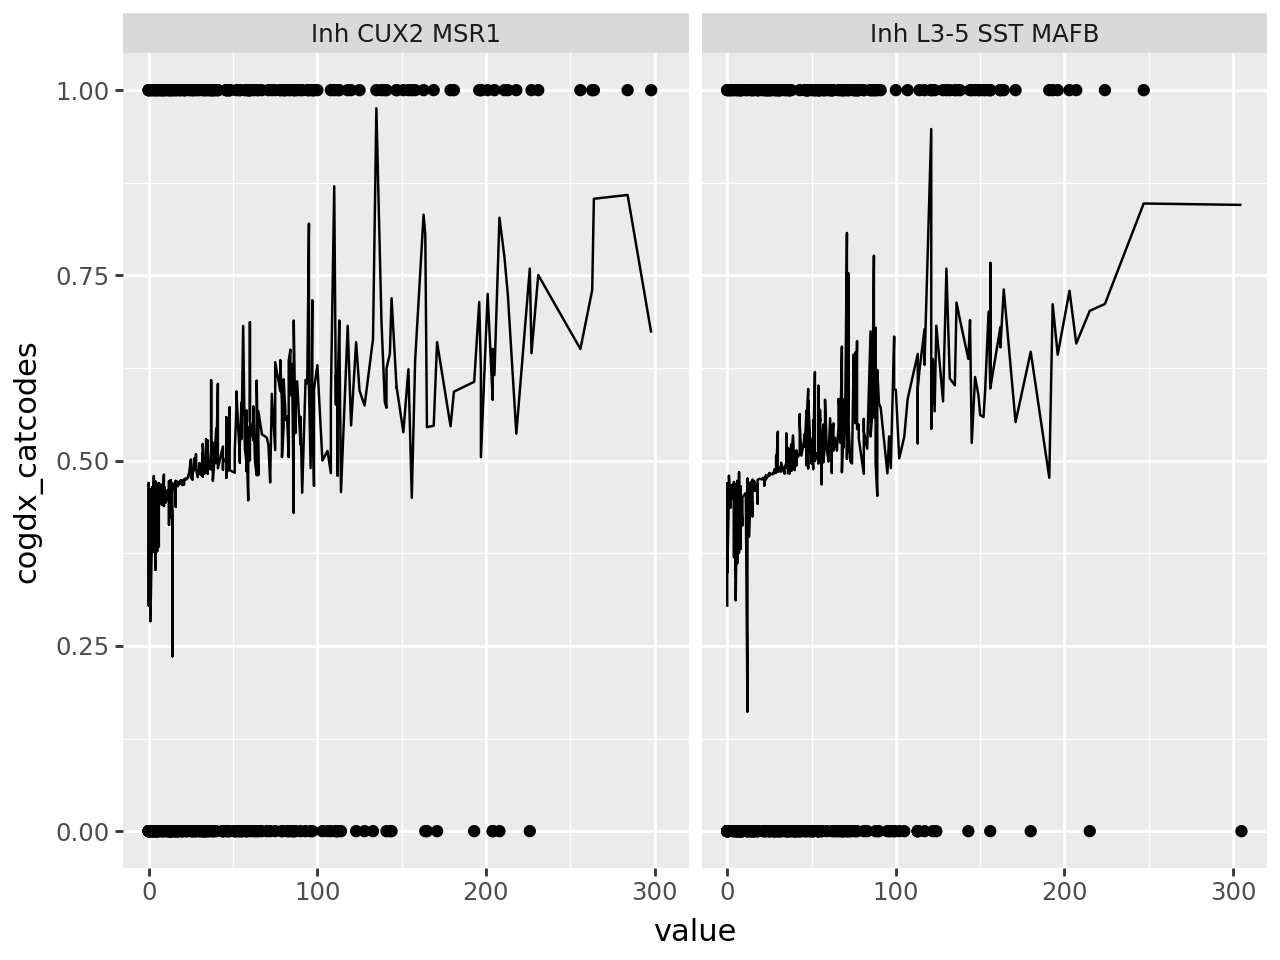

In [10]:
display(melted_data)

plot = ggplot(melted_data, aes(y='cogdx_catcodes', x='value')) +\
    geom_point() +\
    geom_line(aes(y='fittedvalues', x='value')) +\
    facet_wrap('variable')

plot

In [8]:
# Fold change

fold_changes = np.zeros(len(ct_counts_metadata.X.T))
for i, ct in enumerate(ct_counts_metadata.var.index):
    AD = ct_counts_metadata.X[(ct_counts_metadata.obs.cogdx == 4) | (ct_counts_metadata.obs.cogdx == 5), i]
    H = ct_counts_metadata.X[ct_counts_metadata.obs.cogdx == 1, i]
    fold_changes[i] = np.log2(np.mean(AD)/np.mean(H))

ct_counts_metadata.var = ct_counts_metadata.var.assign(log2fc=fold_changes, log10p=np.log10(ct_counts_metadata.var['corr_pvalue'])*-1)
ct_counts_metadata.var.sort_values('corr_pvalue')

,significant,corr_pvalue,log2fc,log10p
Inh L3-5 SST MAFB,True,0.023264,-0.596340,1.633317
Inh CUX2 MSR1,True,0.023264,-0.677598,1.633317
Inh LAMP5 RELN,False,0.107663,-0.724102,0.967932
Exc L5/6 IT Car3,False,0.256725,-0.102517,0.590532
Inh ENOX2 SPHKAP,False,0.256725,-0.482734,0.590532
Exc L6 THEMIS NFIA,False,0.256725,-0.126534,0.590532
Inh VIP TSHZ2,False,0.336037,-0.484059,0.473613
Inh PTPRK FAM19A1,False,0.336037,-0.582404,0.473613
Exc L3-5 RORB PLCH1,False,0.336037,-0.174951,0.473613
Exc L5-6 RORB LINC02196,False,0.336037,-0.204008,0.473613


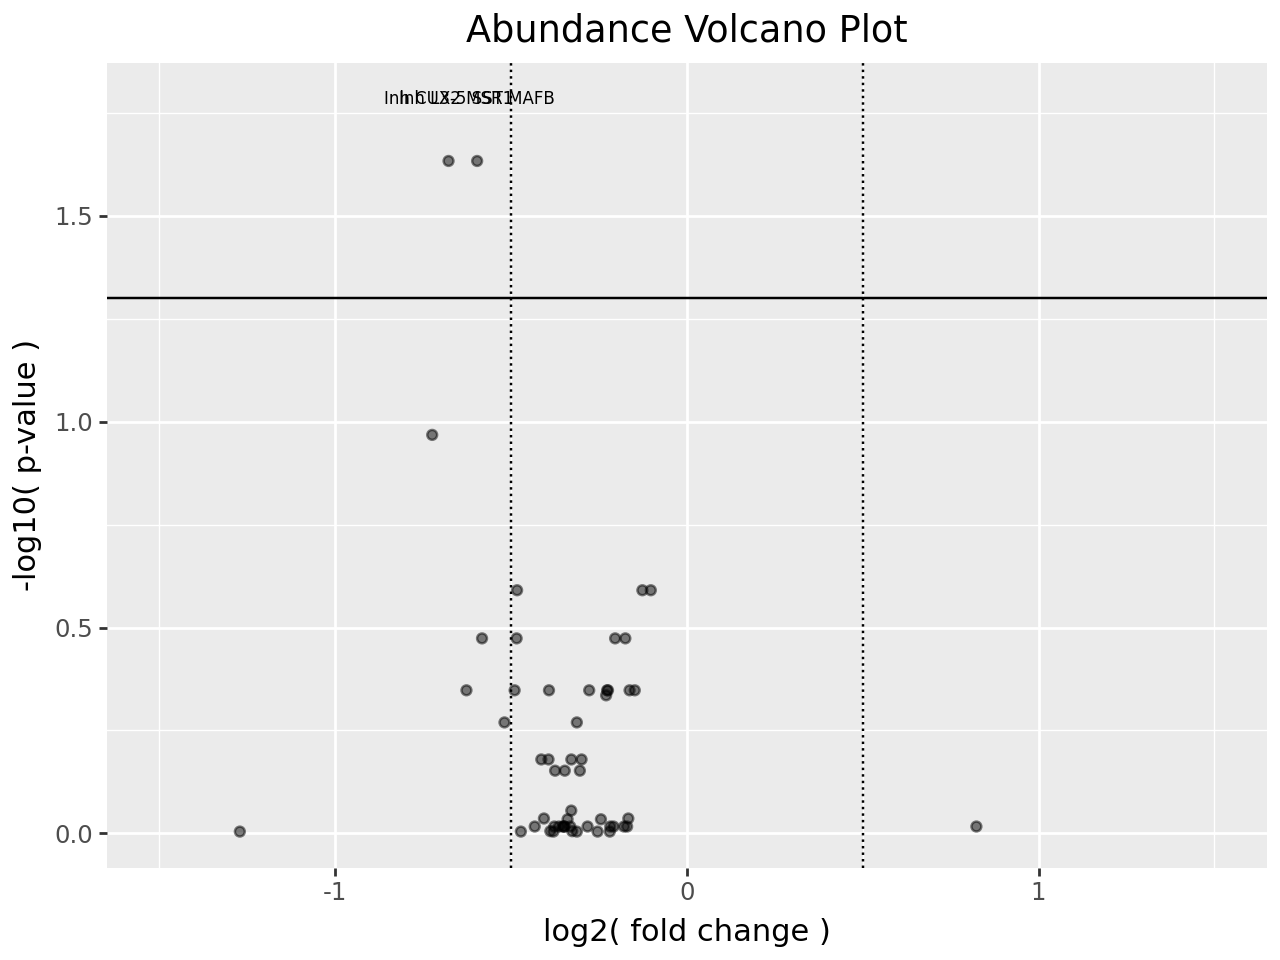

In [9]:
alpha=0.05
ct_counts_metadata.var = ct_counts_metadata.var.reset_index()
volcano_plot = ggplot(ct_counts_metadata.var, aes('log2fc', 'log10p')) +\
    geom_point(alpha=0.5) +\
    geom_hline(yintercept=np.log10(alpha)*-1, color='black') +\
    geom_text(aes(label='index'), data=ct_counts_metadata.var[ct_counts_metadata.var['significant'] == True], color='black', nudge_y=0.15, size=6) +\
    geom_vline(xintercept=(0.5, -0.5), color='black', linetype='dotted') +\
    xlab('log2( fold change )') + ylab('-log10( p-value )') +\
    xlim(-1.5, 1.5) +\
    ggtitle('Abundance Volcano Plot')

volcano_plot